# Audio Classification

In [47]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '20'

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from pathlib import Path
import tensorflow_hub as hub
from IPython.display import Audio, display

## Loading data

In [2]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [3]:
paths = Path().glob('./temp/data/*/*.wav')
paths = [str(path.absolute()) for path in paths]
labels = [int(x.split(os.path.sep)[-1].split('_')[0]) for x in paths]

train_paths, test_paths, train_labels, test_labels = train_test_split(paths, labels, test_size=0.1, random_state=1020)
print(len(paths), 'Loaded!')
print(len(train_paths), 'Training data!')
print(len(test_paths), 'Test data!')

9537 Loaded!
8583 Training data!
954 Test data!


Let's visualize some data

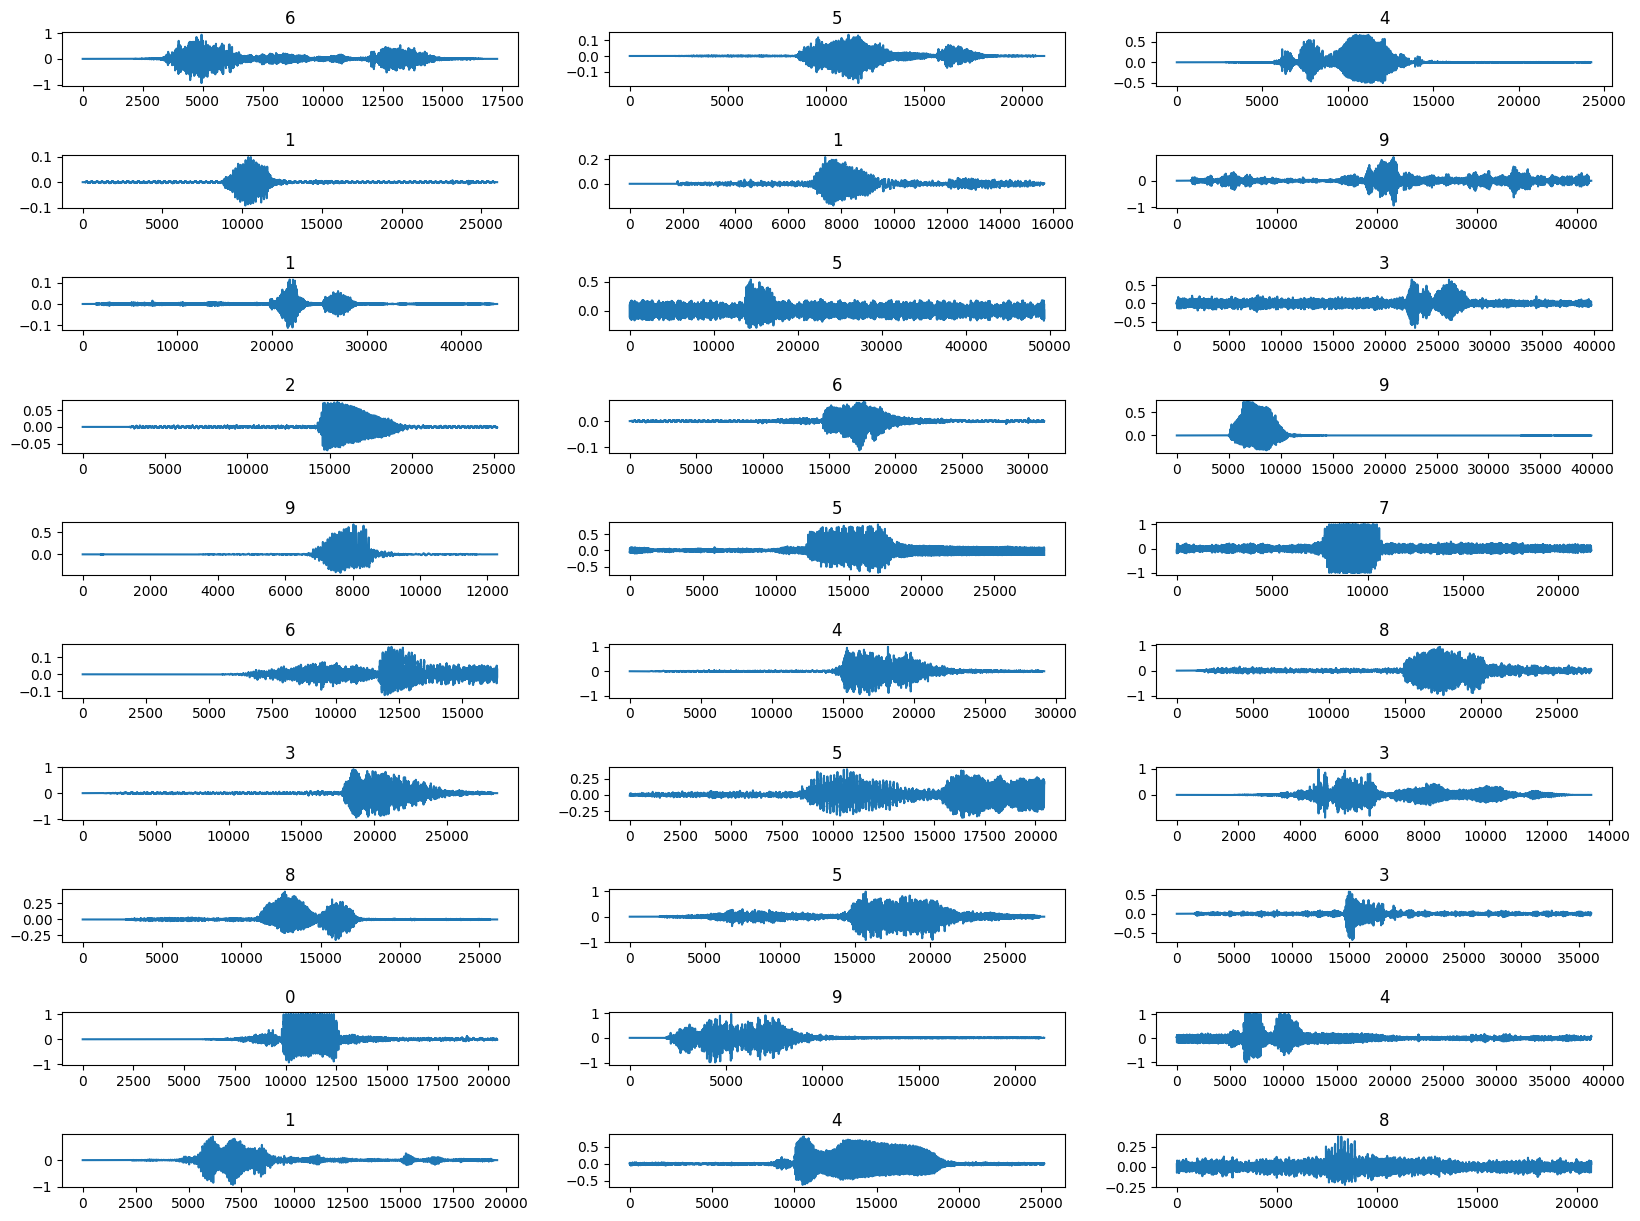

In [4]:
fig = plt.figure(figsize=(20, 15))
for i, (path, lbl) in enumerate(zip(train_paths, train_labels)):
    if i >= 30: break

    ax = plt.subplot(10, 3, i + 1)
    file = tf.io.read_file(path)
    wav, sample_rate = tf.audio.decode_wav(file, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    ax.plot(wav)
    ax.set_title(f'{lbl}')

fig.subplots_adjust(hspace=1.3)

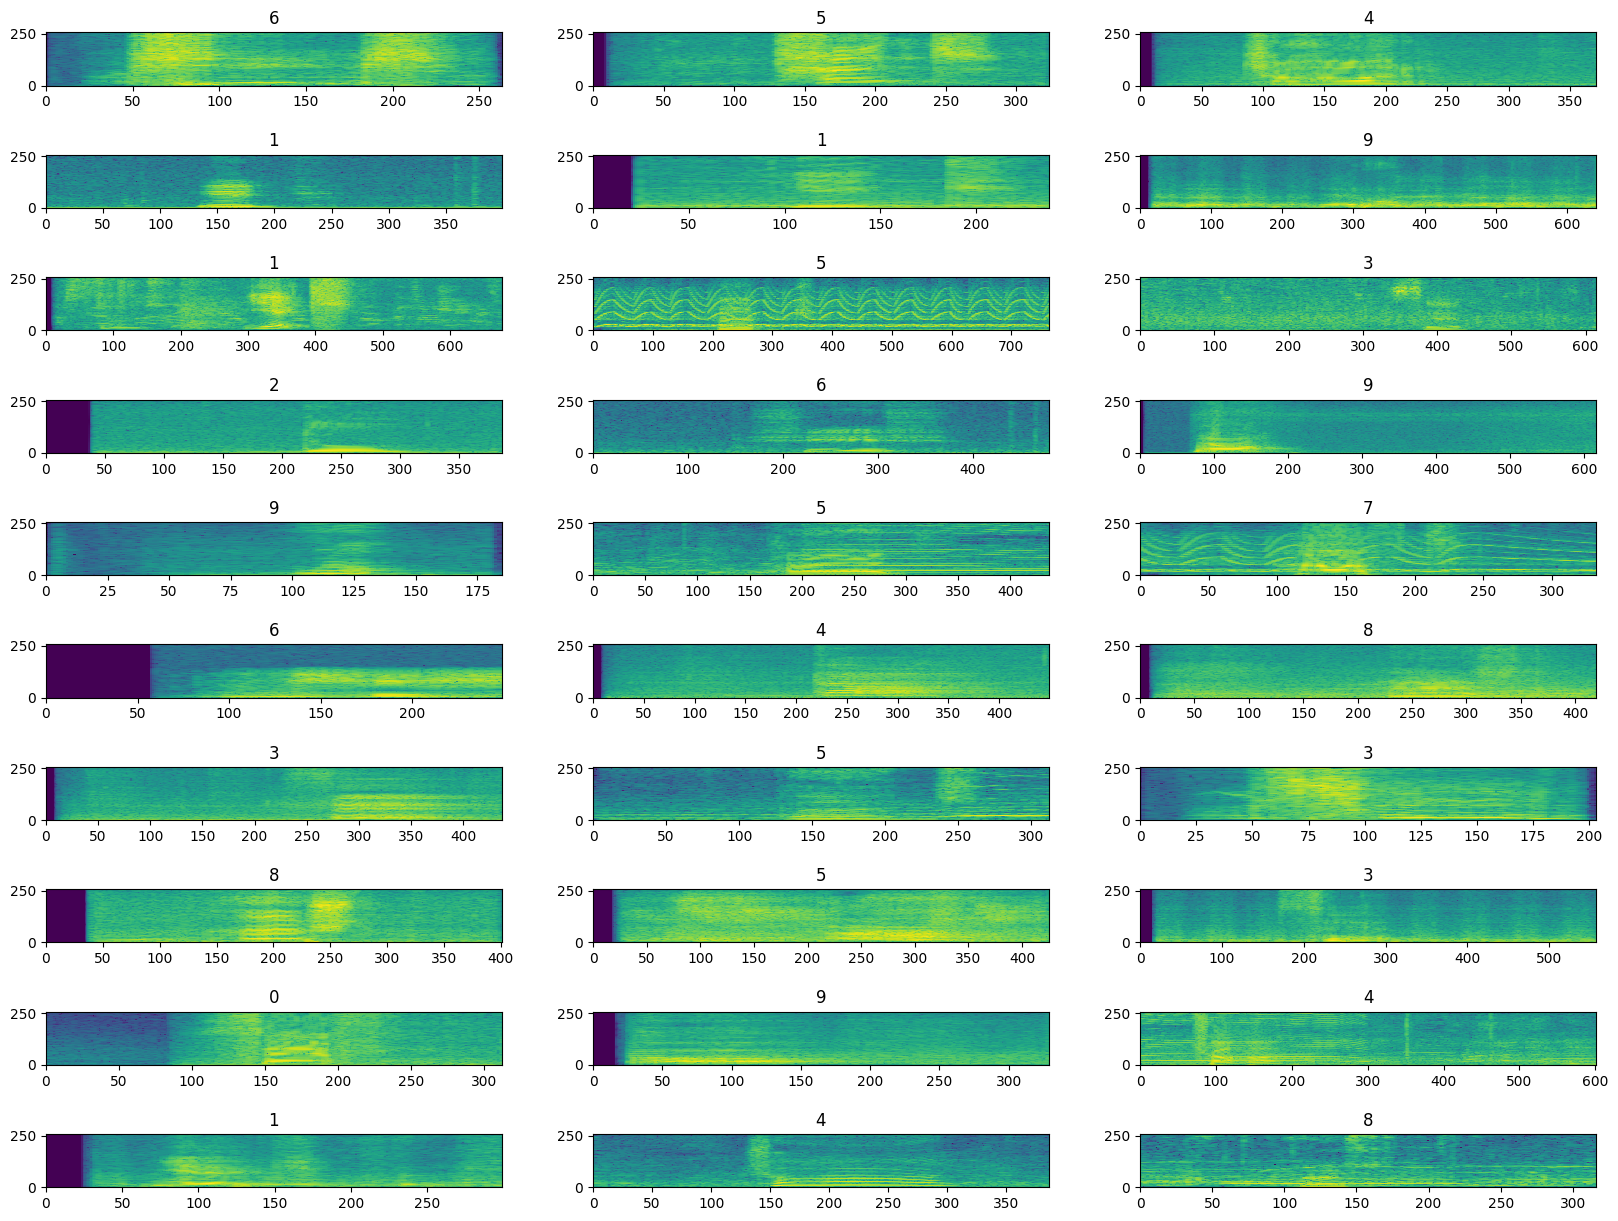

In [5]:
fig = plt.figure(figsize=(20, 15))
for i, (path, lbl) in enumerate(zip(train_paths, train_labels)):
    if i >= 30: break

    ax = plt.subplot(10, 3, i + 1)
    file = tf.io.read_file(path)
    wav, sample_rate = tf.audio.decode_wav(file, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    spectrum = tf.abs(tf.signal.stft(wav, frame_length=511, frame_step=64))

    log_spec = np.log(spectrum.numpy().T + np.finfo(np.float32).eps)
    ax.pcolormesh(log_spec)
    ax.set_title(f'{lbl}')

fig.subplots_adjust(hspace=1.3)

## Building a pipeline

In [6]:
SAMPLE_RATE = 16000
BATCH_SIZE = 64
FRAME_LENGTH = 1024
FRAME_STEP = 512
BUFFER = 10000
AUTOTUNE = tf.data.experimental.AUTOTUNE

def extract_embedding(wav_data, label):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return embeddings, tf.repeat(label, num_embeddings), spectrogram


def load_audio(path):
    file = tf.io.read_file(path)
    wav, sample_rate = tf.audio.decode_wav(file, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    return wav

def get_spectogram(audio):
    spectogram = tf.signal.stft(audio, frame_length=FRAME_LENGTH, frame_step=FRAME_STEP)
    spectogram = tf.abs(spectogram)

    num_spectrogram_bins = spectogram.shape[-1]
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        64, num_spectrogram_bins, 16000, 80.0, 7600.0)

    # Apply the mel-scale filter bank to the magnitude spectrogram
    mel_spectrogram = tf.tensordot(spectogram, linear_to_mel_weight_matrix, 1)
    mel_spectrogram.set_shape(spectogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    return log_mel_spectrogram


def load_dataset(path, label):
    audio = load_audio(path)
    _, _, spectogram = extract_embedding(audio, label)
    return spectogram, label
    

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(load_dataset, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(BUFFER)
train_ds = train_ds.padded_batch(BATCH_SIZE)
train_ds = train_ds.prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(load_dataset, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache()
test_ds = test_ds.padded_batch(BATCH_SIZE)
test_ds = test_ds.prefetch(AUTOTUNE)

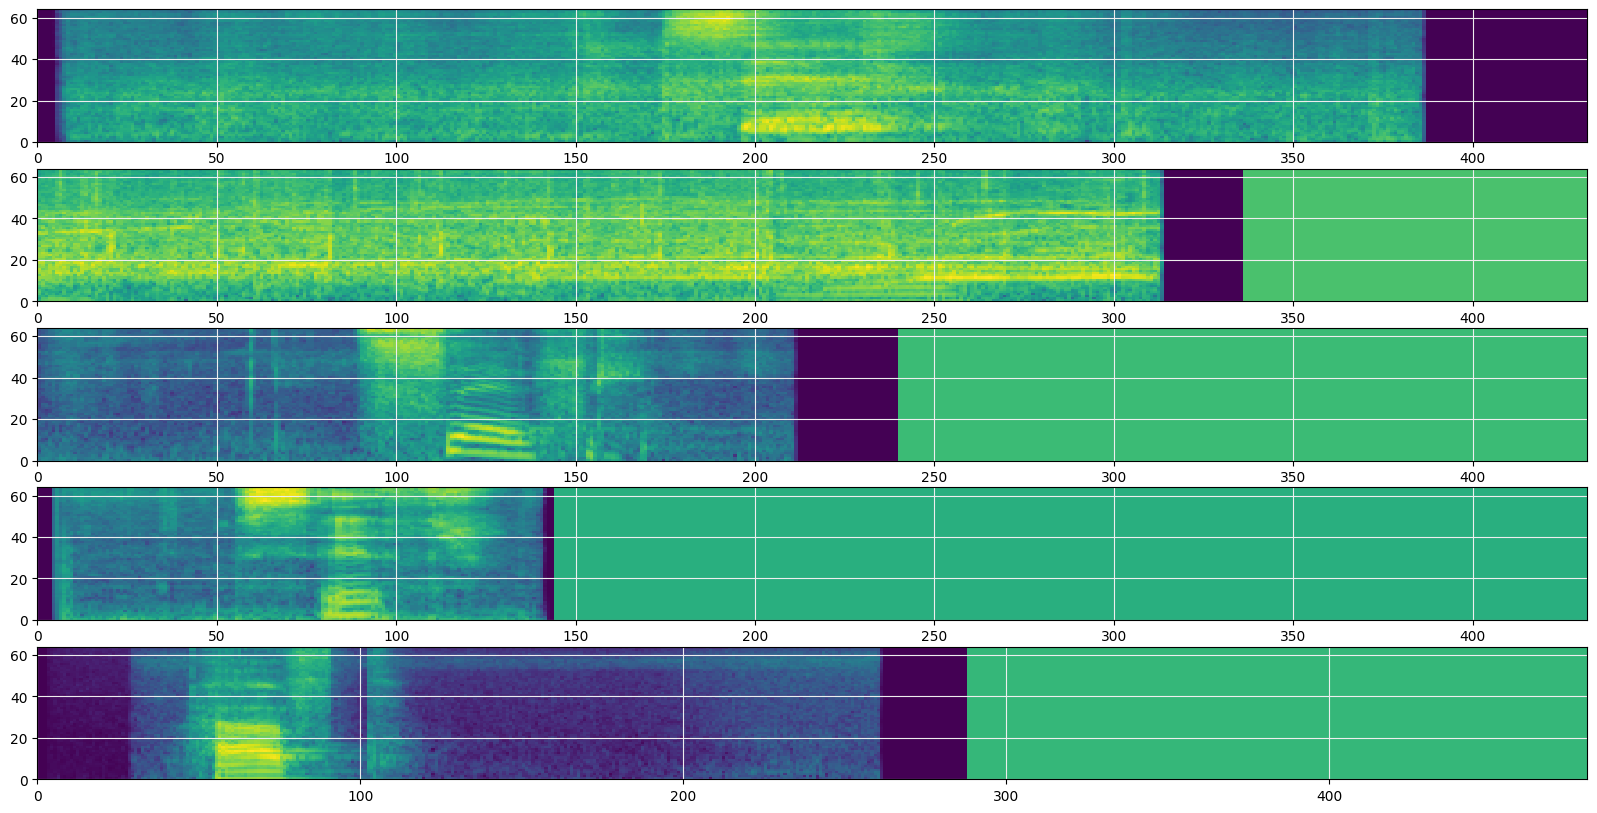

In [7]:
plt.figure(figsize=(20, 10))
for i, (x, y) in enumerate(train_ds.take(5)):
    ax = plt.subplot(5, 1, i + 1)
    ax.pcolormesh(tf.transpose(x[0]))
    ax.grid(c='#eee')
fig.subplots_adjust(hspace=1.3)

### Build the model

In [8]:
from keras.layers import Layer, Conv1D, BatchNormalization, Dropout, Activation, Normalization, Input, MaxPool1D, Dense
from keras.layers import GlobalAveragePooling1D, DepthwiseConv1D, Add, Bidirectional, LSTM, Normalization, MultiHeadAttention
from keras.models import Model
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.metrics import F1Score, CategoricalAccuracy, Precision, Recall
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [9]:
class ConvBlock(Layer):
    def __init__(self, filters, momentum=0.99):
        super(ConvBlock, self).__init__()

        self.conv = Conv1D(filters=filters, 
                           kernel_size=3, 
                           padding='same', 
                           name='conv')
        
        self.bn = BatchNormalization(momentum=momentum, 
                                     name='bn')
        
        self.act = Activation('relu', 
                              name='act')

    def call(self, input_tensor, training=False):
        x = self.conv(input_tensor)
        x = self.bn(x, training=training)
        x = self.act(x)
        return x

In [10]:
class ResBlock(Layer):
    def __init__(self, filters, momentum=0.99):
        super(ResBlock, self).__init__()

        self.conv_block1 = ConvBlock(filters[0],
                                     momentum=momentum)
        
        self.conv_block2 = ConvBlock(filters[1],
                                     momentum=momentum)
        
        self.conv_block3 = ConvBlock(filters=filters[2], 
                                     momentum=momentum)
        
        self.skip_connection = Conv1D(filters=filters[1], 
                                      kernel_size=1, 
                                      activation='linear', 
                                      name='skip_connection')
        
        self.maxpool = MaxPool1D(name='maxpool')
        

    def call(self, input_tensor, training=False):
        x = self.conv_block1(input_tensor)
        x = self.conv_block2(x)
        skipped = self.skip_connection(input_tensor)
        x = self.conv_block3(tf.add(x, skipped))
        x = self.maxpool(x)
        return x

In [11]:
class ResNet(Model):
    def __init__(self, num_classes, momentum=0.99):
        super(ResNet, self).__init__()

        self.norm = Normalization()
        self.norm.adapt(train_ds.map(lambda x, y: x, num_parallel_calls=AUTOTUNE))
        
        self.base_conv = Conv1D(filters=64,
                                kernel_size=7, 
                                padding='same',
                                name='base_conv')

        self.bn = BatchNormalization(name='bn', 
                                     momentum=momentum)

        self.act = Activation('relu', name='act')

        self.maxpool = MaxPool1D(name='maxpool')

        self.res_block1 = ResBlock(filters=[64, 64, 128], momentum=momentum)
        self.res_block2 = ResBlock(filters=[128, 128, 256], momentum=momentum)
        self.res_block3 = ResBlock(filters=[256, 256, 512], momentum=momentum)

        self.global_avg = GlobalAveragePooling1D(name='global_avg')

        self.dropout = Dropout(0.7, name='dropout')
        self.classifier = Dense(num_classes)


    def build(self, input_shape):
        inputs = Input(shape=input_shape)
        self.call(inputs)
        self.built = True


    def call(self, input_tensor, training=False):
        x = self.norm(input_tensor)
        x = self.base_conv(x)
        x = self.bn(x, training=training)
        x = self.act(x)
        x = self.maxpool(x)

        x = self.res_block1(x, training=training)
        x = self.res_block2(x, training=training)
        x = self.res_block3(x, training=training)

        x = self.global_avg(x)
        x = self.dropout(x, training=training)
        x = self.classifier(x)
        return x

In [12]:
model = ResNet(10, momentum=0.5)
model.build(input_shape=x.shape[1:])
model.summary()

Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 480, 64)           129       
 on)                                                             
                                                                 
 base_conv (Conv1D)          (None, 480, 64)           28736     
                                                                 
 bn (BatchNormalization)     (None, 480, 64)           256       
                                                                 
 act (Activation)            (None, 480, 64)           0         
                                                                 
 maxpool (MaxPooling1D)      (None, 240, 64)           0         
                                                                 
 res_block (ResBlock)        (None, 120, 128)          54592     
                                                           

In [13]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(),
    metrics=['accuracy']
)

def get_scheduler(initial_learning_rate, weight=0.99, min_learning_rate=1e-5):
    def func(epoch):
        return max(min_learning_rate, initial_learning_rate * weight ** epoch)
    return func


scheduler = get_scheduler(3e-3, weight=0.97)
lr_scheduler = LearningRateScheduler(scheduler)
checkpoint = ModelCheckpoint('./checkpoints/resnet/best.h5', 
                             save_best_only=True, 
                             save_weights_only=True)
callbacks = [lr_scheduler, checkpoint]

In [14]:
history = model.fit(train_ds, epochs=100, validation_data=test_ds, callbacks=callbacks)

Epoch 1/100


I0000 00:00:1718036517.848192   67351 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


135/135 [==============================] - 43s 218ms/step - loss: 1.8851 - accuracy: 0.3296 - val_loss: 1.3577 - val_accuracy: 0.5178 - lr: 0.0030
Epoch 2/100
135/135 [==============================] - 5s 38ms/step - loss: 1.1605 - accuracy: 0.5753 - val_loss: 0.8932 - val_accuracy: 0.6478 - lr: 0.0029
Epoch 3/100
135/135 [==============================] - 4s 30ms/step - loss: 0.8442 - accuracy: 0.6938 - val_loss: 0.7136 - val_accuracy: 0.7432 - lr: 0.0028
Epoch 4/100
135/135 [==============================] - 6s 48ms/step - loss: 0.6656 - accuracy: 0.7786 - val_loss: 0.5855 - val_accuracy: 0.8092 - lr: 0.0027
Epoch 5/100
135/135 [==============================] - 4s 30ms/step - loss: 0.5206 - accuracy: 0.8219 - val_loss: 0.4811 - val_accuracy: 0.8375 - lr: 0.0027
Epoch 6/100
135/135 [==============================] - 7s 50ms/step - loss: 0.4192 - accuracy: 0.8583 - val_loss: 0.4110 - val_accuracy: 0.8595 - lr: 0.0026
Epoch 7/100
135/135 [==============================] - 4s 30ms/step 

## Evaluation

In [15]:
from sklearn.metrics import classification_report

def plot(history, key, ax):
    val_key = 'val_' + key
    ax.plot(history.epoch, history.history[key], label=key)
    ax.plot(history.epoch, history.history[val_key], label=val_key)
    ax.grid(c='#eee')
    ax.set_title(f'{key.capitalize()} per epoch')
    ax.set_xlabel('epoch')
    ax.set_ylabel(f'{key}')
    plt.legend();

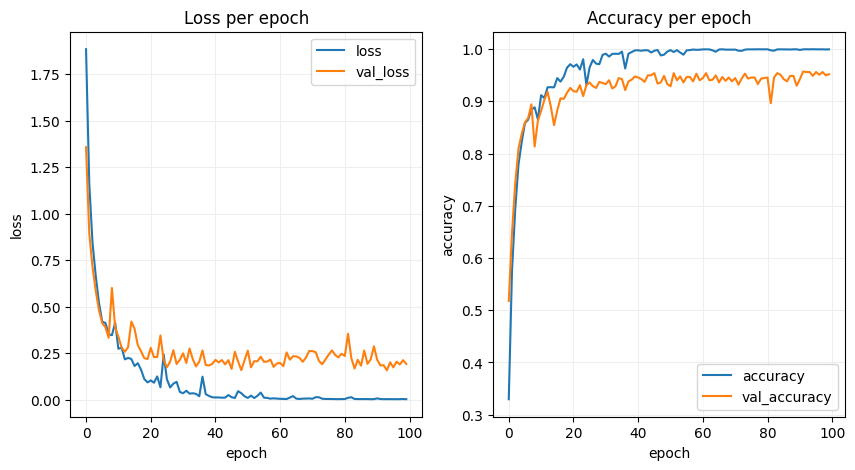

In [16]:
fig = plt.figure(figsize=(10, 5))

ax = plt.subplot(1, 2, 1)
plot(history, 'loss', ax);

ax = plt.subplot(1, 2, 2)
plot(history, 'accuracy', ax);

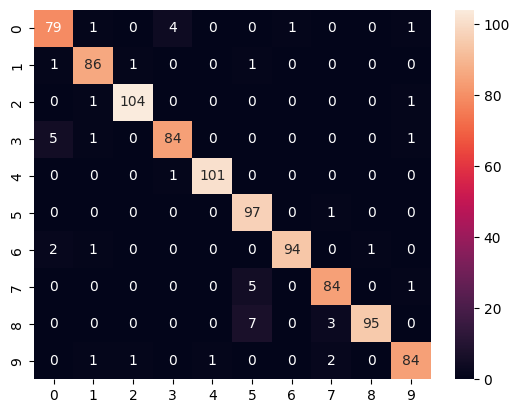

In [17]:
pred = model.predict(test_ds, verbose=0)
pred = tf.argmax(pred, axis=-1)

y_true = tf.concat([l for s, l in test_ds], axis=-1)

conf_matrix = tf.math.confusion_matrix(y_true, pred)

classes = [str(i) for i in range(10)]
sns.heatmap(conf_matrix, annot=True, xticklabels=classes, yticklabels=classes, fmt='g');

In [18]:
print(classification_report(y_true, pred, target_names=classes))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91        86
           1       0.95      0.97      0.96        89
           2       0.98      0.98      0.98       106
           3       0.94      0.92      0.93        91
           4       0.99      0.99      0.99       102
           5       0.88      0.99      0.93        98
           6       0.99      0.96      0.97        98
           7       0.93      0.93      0.93        90
           8       0.99      0.90      0.95       105
           9       0.95      0.94      0.95        89

    accuracy                           0.95       954
   macro avg       0.95      0.95      0.95       954
weighted avg       0.95      0.95      0.95       954



## Export Model

In [65]:
class ExportModel(tf.Module):
    def __init__(self, model, extract_embedding):
        super(ExportModel, self).__init__()

        self.model = model
        self.extract_embedding = extract_embedding


    def create_pipeline(self, filenames):
        BATCH_SIZE = tf.cast(tf.shape(filenames)[0], tf.int64)
        AUTOTUNE = tf.data.experimental.AUTOTUNE
        
        pipeline = tf.data.Dataset.from_tensor_slices(filenames)
        pipeline = pipeline.map(lambda x: tf.io.read_file(x), num_parallel_calls=AUTOTUNE)
        pipeline = pipeline.map(lambda x: tf.audio.decode_wav(x, desired_channels=1)[0], num_parallel_calls=AUTOTUNE)
        pipeline = pipeline.map(lambda x: tf.squeeze(x, axis=-1), num_parallel_calls=AUTOTUNE)
        pipeline = pipeline.map(lambda x: self.extract_embedding(x, 1)[-1], num_parallel_calls=AUTOTUNE)
        pipeline = pipeline.padded_batch(BATCH_SIZE)
        pipeline = pipeline.prefetch(AUTOTUNE)
        return pipeline


    @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None,])])
    def __call__(self, filenames):
        pipeline = self.create_pipeline(filenames)
        data = next(iter(pipeline))
        predictions = self.model(data, training=False)
        predictions = tf.argmax(predictions, axis=-1)
        return predictions

In [69]:
exportModel = ExportModel(model, extract_embedding)
y_pred = exportModel(tf.convert_to_tensor(test_paths))

for i in range(10):
    print(f'Predicted {y_pred[i]} and the actual label is {test_labels[i]}')
    display(Audio(filename=test_paths[i]))

Predicted 2 and the actual label is 2


Predicted 3 and the actual label is 3


Predicted 8 and the actual label is 8


Predicted 2 and the actual label is 2


Predicted 4 and the actual label is 4


Predicted 6 and the actual label is 6


Predicted 5 and the actual label is 5


Predicted 0 and the actual label is 0


Predicted 2 and the actual label is 2


Predicted 4 and the actual label is 4


In [70]:
model.save('./models/resnet.tf')

INFO:tensorflow:Assets written to: ./models/resnet.tf/assets


INFO:tensorflow:Assets written to: ./models/resnet.tf/assets


In [71]:
converter = tf.lite.TFLiteConverter.from_saved_model('./models/resnet.tf/')
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.SELECT_TF_OPS,
    tf.lite.OpsSet.TFLITE_BUILTINS
]

converter._experimental_lower_tensor_list_ops = False
tflite = converter.convert()

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 57, Total Ops 148, % non-converted = 38.51 %
 * 57 ARITH ops

- arith.constant:   57 occurrences  (f32: 54, i32: 3)



  (f32: 26)
  (f32: 13)
  (f32: 14)
  (f32: 1)
  (f32: 4)
  (f32: 1)
  (f32: 11)
  (f32: 17)
  (f32: 1)


In [73]:
with open('./models/resnet_tflite.tflite', 'wb') as writer:
    writer.write(tflite)